In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

from scipy.stats import entropy
import pandas as pd
import numpy as np
import onnxruntime as rt

import matplotlib.pyplot as plt
import numpy as np

In [6]:
# constants and parameters definition

data_path = '../data/300k_dataset.csv'
good_model_path = '../model/good_model.onnx'
biased_model_path = '../model/biased_model.onnx'

In [9]:
def equivalence_testing_with_bins(
        model_path, data_address, sensitive_attributes, bins=5
):
    """
    等价测试方法，针对连续敏感属性进行分箱后测试 KL 散度。

    :param model_path: 模型路径
    :param data_address: 数据文件地址
    :param sensitive_attributes: 敏感属性列表
    :param bins: 分箱数量（默认为 5）
    :return: 分析结果字典
    """
    data = pd.read_csv(data_address)
    X = data.drop(['checked', 'Ja', 'Nee'], axis=1).astype(np.float32)

    session = rt.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name

    results = {}

    for attr in sensitive_attributes:
        print(f"Testing sensitive attribute: {attr}")

        # 如果是连续属性，进行分箱
        if data[attr].dtype in [np.float64, np.int64]:
            data[f"{attr}_bins"] = pd.cut(data[attr], bins=bins)
            unique_values = data[f"{attr}_bins"].unique()
        else:
            unique_values = data[attr].unique()

        distributions = {}

        # 计算每个区间的预测分布
        for value in unique_values:
            if pd.isnull(value):  # 忽略空值
                continue

            if data[attr].dtype in [np.float64, np.int64]:
                mask = (data[f"{attr}_bins"] == value)
            else:
                mask = (data[attr] == value)

            sub_X = X[mask]

            preds = session.run(None, {input_name: sub_X.values})[0]
            if preds.ndim > 1:
                preds = np.argmax(preds, axis=1)

            dist = np.bincount(preds, minlength=np.max(preds) + 1) / len(preds)
            distributions[value] = dist

        # 计算 KL 散度
        metrics = []
        for i, value1 in enumerate(unique_values):
            for j, value2 in enumerate(unique_values):
                if i < j and value1 is not None and value2 is not None:
                    kl_div = entropy(distributions[value1], qk=distributions[value2])
                    metrics.append({
                        "value1": value1,
                        "value2": value2,
                        "kl_divergence": kl_div
                    })

        results[attr] = pd.DataFrame(metrics)
        print(f"Results for {attr}:\n", results[attr])

    return results

def visualize_equivalence_testing_with_bins(results):
    """
    可视化等价测试结果，使用区间的 KL 散度热力图。

    :param results: `equivalence_testing_with_bins` 返回的结果
    """
    for attr, df in results.items():
        pivot_kl = df.pivot(index="value1", columns="value2", values="kl_divergence")
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            pivot_kl, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'KL Divergence'}
        )
        plt.title(f"KL Divergences for Sensitive Attribute: {attr}")
        plt.xlabel(f"{attr} Value 2")
        plt.ylabel(f"{attr} Value 1")
        plt.tight_layout()
        plt.show()


Testing sensitive attribute: persoon_leeftijd_bij_onderzoek
Results for persoon_leeftijd_bij_onderzoek:
          value1          value2  kl_divergence
0  (57.2, 67.0]    (47.4, 57.2]       0.006729
1  (57.2, 67.0]    (27.8, 37.6]       0.064595
2  (57.2, 67.0]    (37.6, 47.4]       0.027143
3  (57.2, 67.0]  (17.951, 27.8]       0.126170
4  (47.4, 57.2]    (27.8, 37.6]       0.034365
5  (47.4, 57.2]    (37.6, 47.4]       0.008074
6  (47.4, 57.2]  (17.951, 27.8]       0.085195
7  (27.8, 37.6]    (37.6, 47.4]       0.011891
8  (27.8, 37.6]  (17.951, 27.8]       0.014076
9  (37.6, 47.4]  (17.951, 27.8]       0.045952
Testing sensitive attribute: persoon_geslacht_vrouw
Results for persoon_geslacht_vrouw:
           value1      value2  kl_divergence
0  (-0.001, 0.2]  (0.8, 1.0]       0.001121
Testing sensitive attribute: persoonlijke_eigenschappen_dagen_sinds_opvoer
Results for persoonlijke_eigenschappen_dagen_sinds_opvoer:
              value1            value2  kl_divergence
0   (-2.377, 

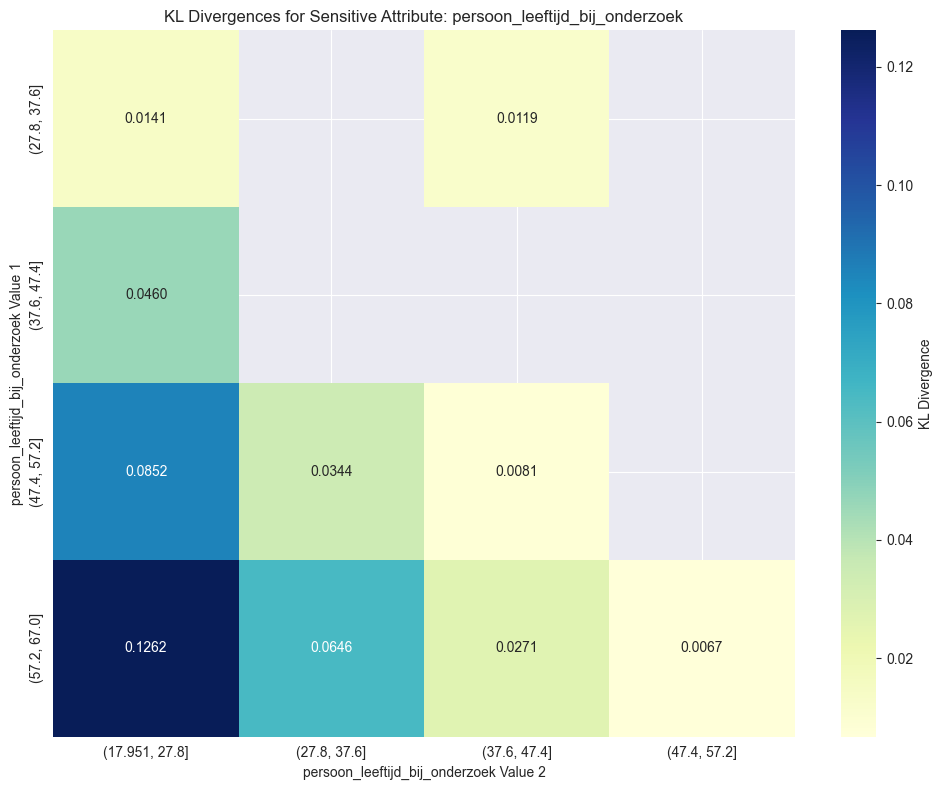

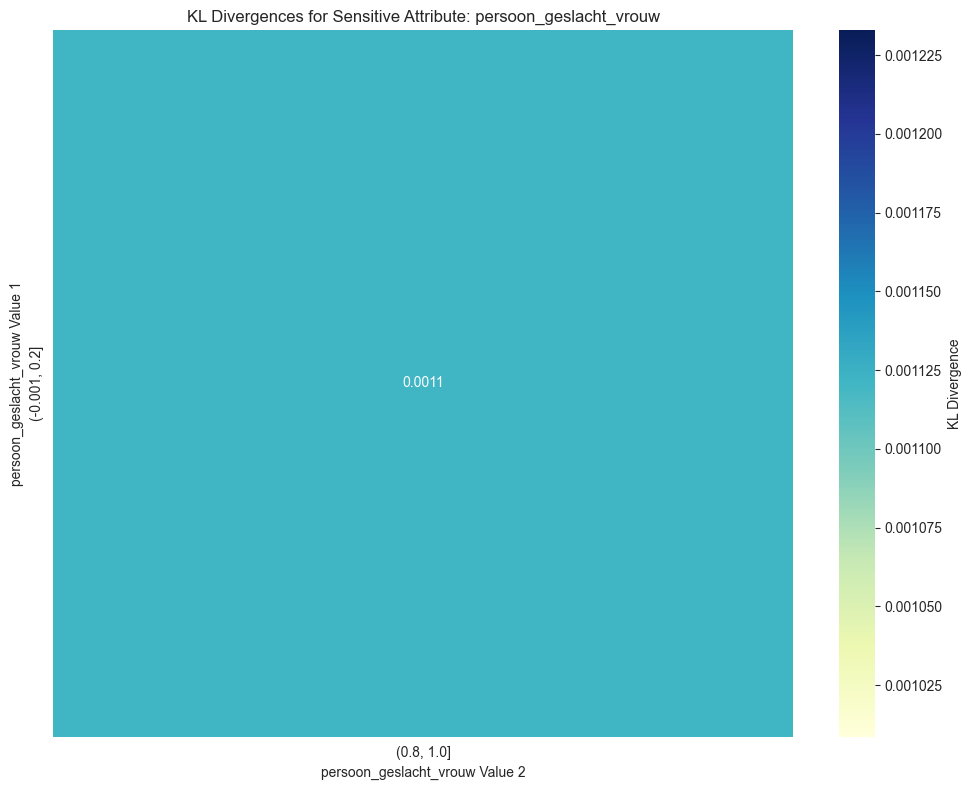

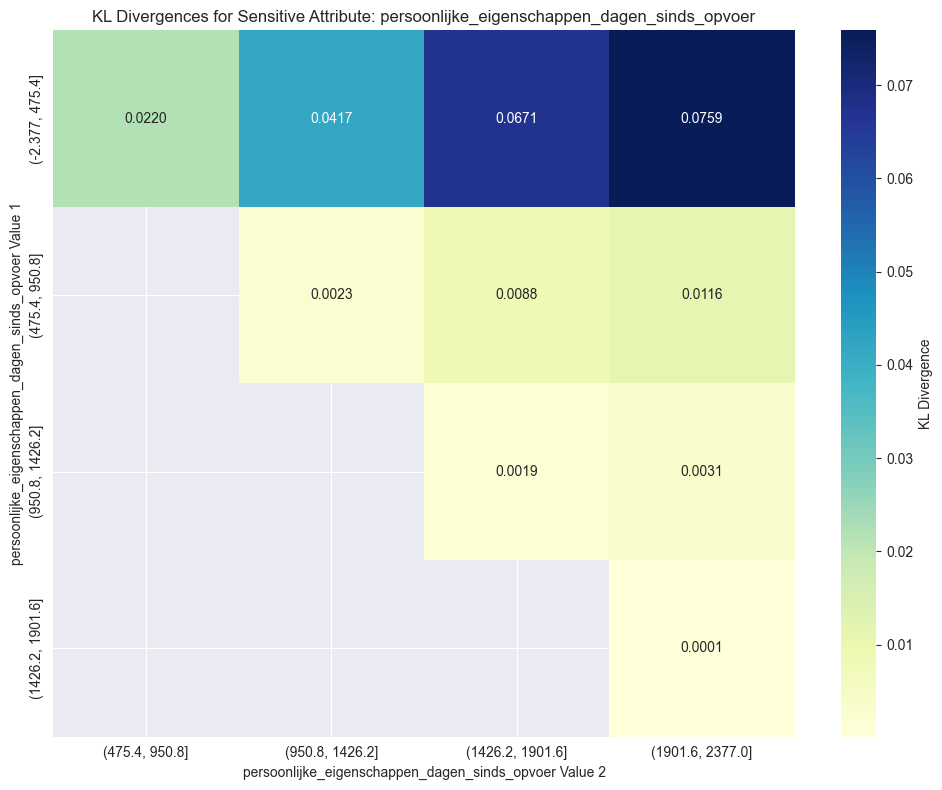

In [10]:
results = equivalence_testing_with_bins(good_model_path, data_path, ["persoon_leeftijd_bij_onderzoek", "persoon_geslacht_vrouw", "persoonlijke_eigenschappen_dagen_sinds_opvoer"], bins=5)
visualize_equivalence_testing_with_bins(results)


In [3]:
# functions definition

def equivalence_testing_with_kl(model_path, data_address, sensitive_attributes):

    data = pd.read_csv(data_address)
    X = data.drop(['checked', 'Ja', 'Nee'], axis=1)
    sensitive_data = data[sensitive_attributes]
    X = X.astype(np.float32)


    session = rt.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name

    kl_results = {}

    for attr in sensitive_attributes:
        print(f"Testing KL divergence for attribute: {attr}")

        unique_values = sensitive_data[attr].unique()
        if len(unique_values) < 2:
            print(f"Attribute {attr} has less than two unique values, skipping.")
            continue

        distributions = {}
        for value in unique_values:

            mask = (sensitive_data[attr] == value)
            sub_X = X[mask]

            preds = session.run(None, {input_name: sub_X.values.astype(np.float32)})[0]
            if preds.ndim > 1:
                preds = np.argmax(preds, axis=1)

            dist = np.bincount(preds, minlength=np.max(preds) + 1) / len(preds)
            distributions[value] = dist

        kl_divergences = []
        for i, value1 in enumerate(unique_values):
            for j, value2 in enumerate(unique_values):
                if i < j: 
                    kl_div = entropy(distributions[value1], qk=distributions[value2])
                    kl_divergences.append({
                        "value1": value1,
                        "value2": value2,
                        "kl_divergence": kl_div
                    })

        kl_results[attr] = pd.DataFrame(kl_divergences)

        print(f"KL Divergences for {attr}:")
        print(kl_results[attr])

    return kl_results

def visualize_kl_results_heatmap(kl_results):
    """
    使用热力图可视化 KL 散度结果。
    
    :param kl_results: `equivalence_testing_with_kl` 返回的分析结果。
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    for attr, df in kl_results.items():
        # 创建数据透视表
        pivot_table = df.pivot(index="value1", columns="value2", values="kl_divergence")

        # 绘制热力图
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            pivot_table,
            annot=True,
            fmt=".4f",
            cmap="YlGnBu",
            cbar_kws={'label': 'KL Divergence'}
        )
        plt.title(f"KL Divergences for Sensitive Attribute: {attr}")
        plt.xlabel(f"{attr} Value 2")
        plt.ylabel(f"{attr} Value 1")
        plt.tight_layout()
        plt.show()

Testing KL divergence for attribute: persoon_leeftijd_bij_onderzoek
KL Divergences for persoon_leeftijd_bij_onderzoek:
      value1  value2  kl_divergence
0         62      53       0.002471
1         62      54       0.002483
2         62      50       0.008013
3         62      32       0.065218
4         62      57       0.000693
...      ...     ...            ...
1220      22      18       0.013661
1221      22      20       0.001053
1222      19      18       0.001689
1223      19      20       0.002052
1224      18      20       0.007632

[1225 rows x 3 columns]
Testing KL divergence for attribute: persoon_geslacht_vrouw
KL Divergences for persoon_geslacht_vrouw:
   value1  value2  kl_divergence
0       0       1       0.001123
Testing KL divergence for attribute: persoonlijke_eigenschappen_spreektaal
KL Divergences for persoonlijke_eigenschappen_spreektaal:
     value1  value2  kl_divergence
0        57       0       0.000094
1        57      73       0.000146
2        57      

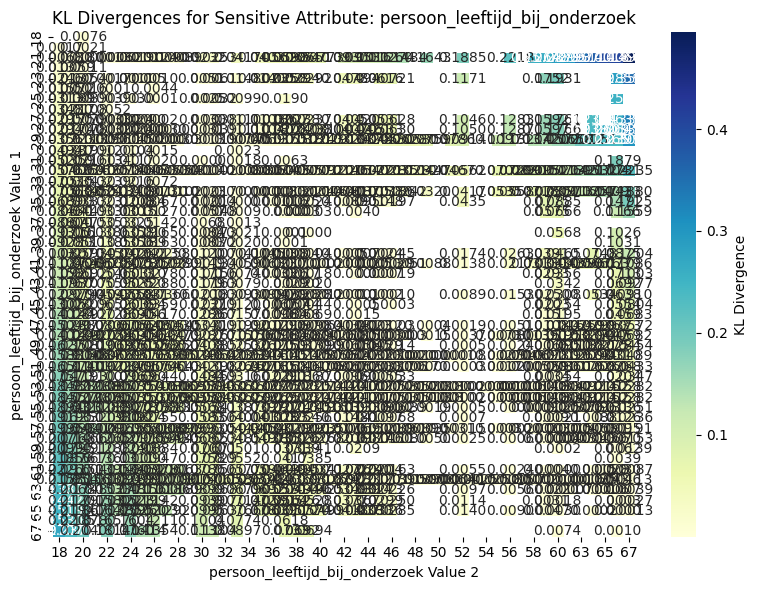

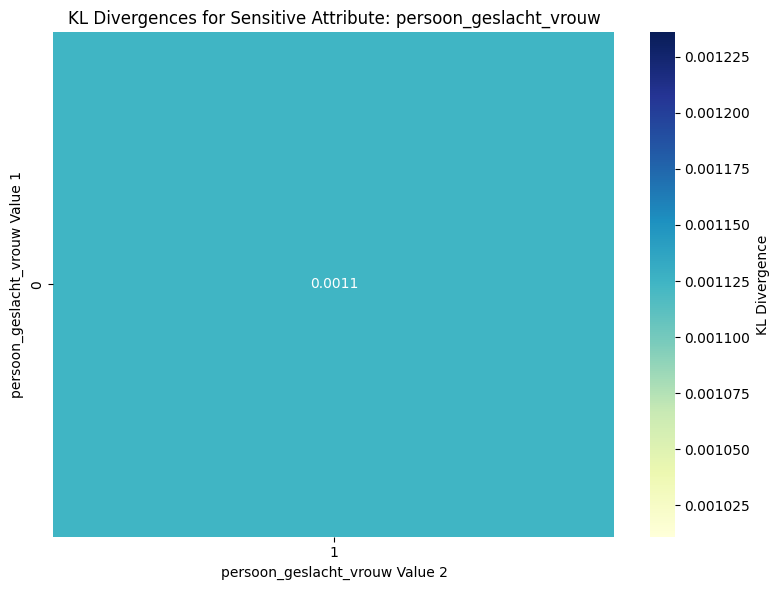

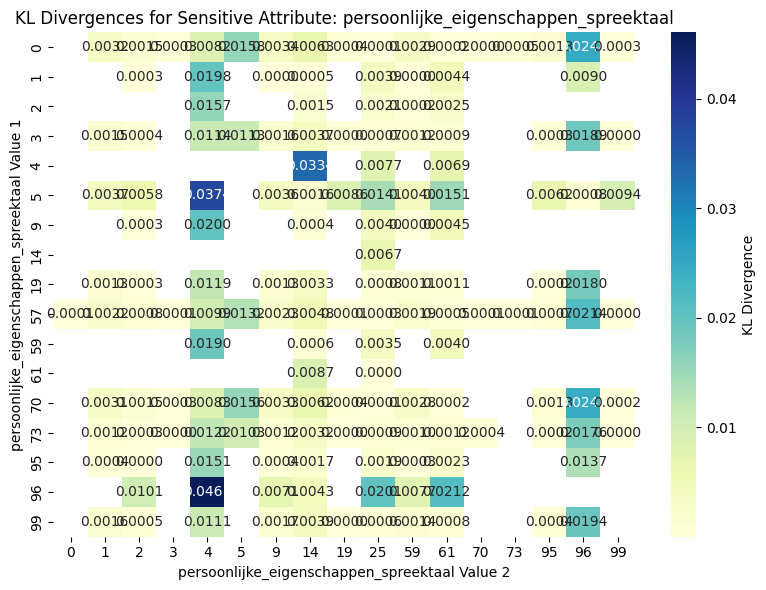

In [4]:
# test and visualize

results = equivalence_testing_with_kl(
    good_model_path,
    data_path,
    sensitive_attributes = ['persoon_leeftijd_bij_onderzoek', 'persoon_geslacht_vrouw', 'persoonlijke_eigenschappen_spreektaal']
)
visualize_kl_results_heatmap(results)

Testing KL divergence for attribute: persoon_leeftijd_bij_onderzoek
KL Divergences for persoon_leeftijd_bij_onderzoek:
      value1  value2  kl_divergence
0         62      53       0.004599
1         62      54       0.002773
2         62      50       0.013565
3         62      32       0.282269
4         62      57       0.002393
...      ...     ...            ...
1220      22      18       0.005742
1221      22      20       0.000967
1222      19      18       0.001889
1223      19      20       0.022855
1224      18      20       0.011549

[1225 rows x 3 columns]
Testing KL divergence for attribute: persoon_geslacht_vrouw
KL Divergences for persoon_geslacht_vrouw:
   value1  value2  kl_divergence
0       0       1       0.001611
Testing KL divergence for attribute: persoonlijke_eigenschappen_spreektaal
KL Divergences for persoonlijke_eigenschappen_spreektaal:
     value1  value2  kl_divergence
0        57       0       0.000123
1        57      73       0.000034
2        57      

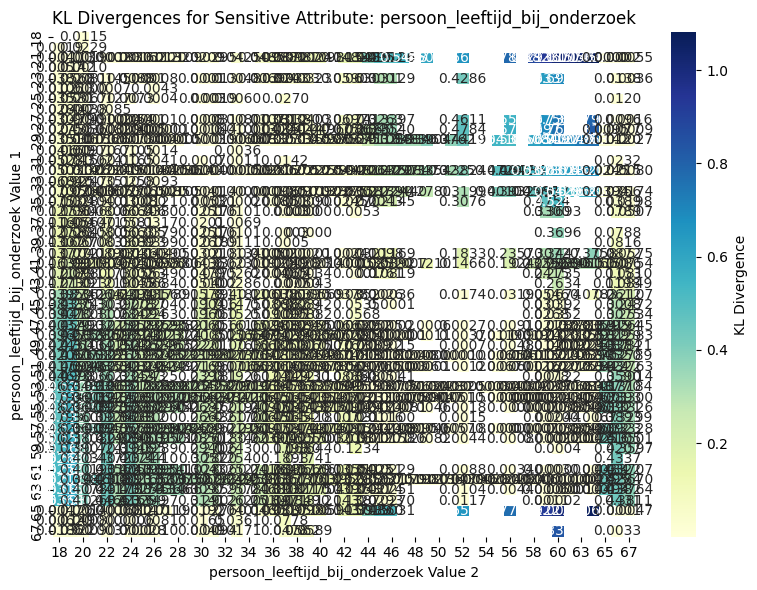

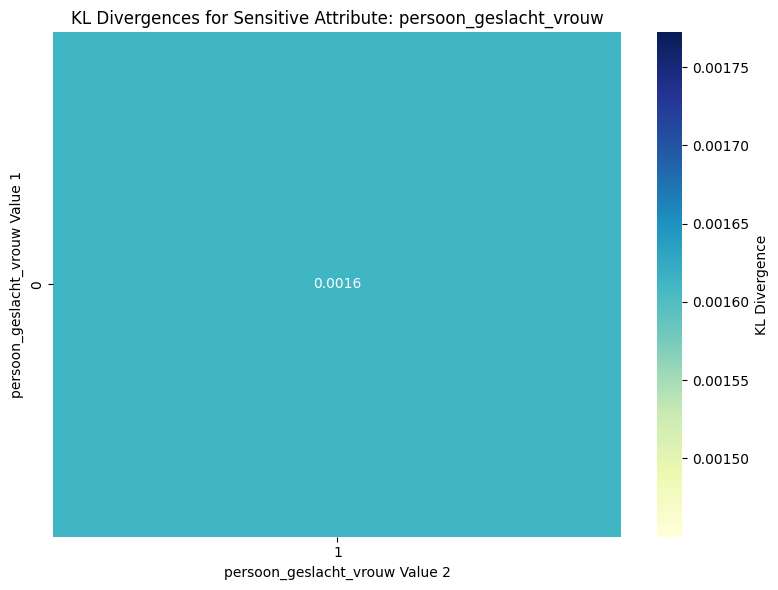

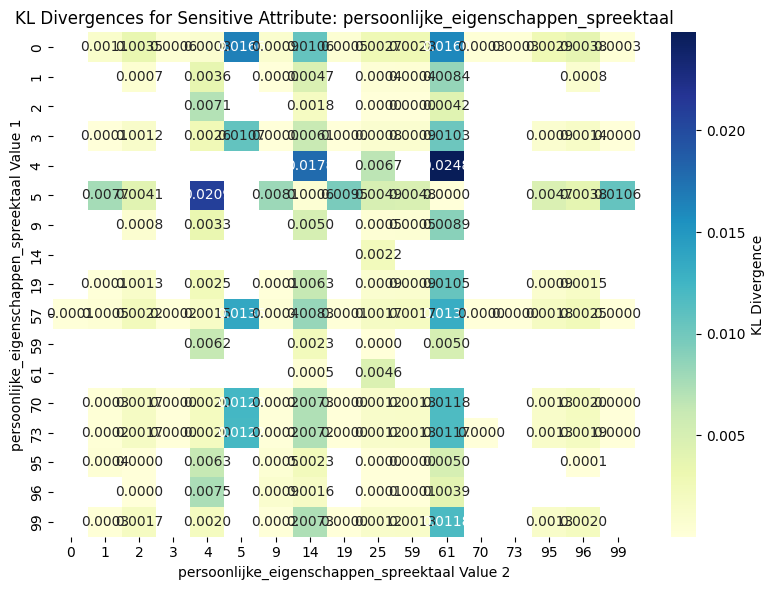

In [5]:
# test and visualize

results = equivalence_testing_with_kl(
    biased_model_path,
    data_path,
    sensitive_attributes = ['persoon_leeftijd_bij_onderzoek', 'persoon_geslacht_vrouw', 'persoonlijke_eigenschappen_spreektaal']
)
visualize_kl_results_heatmap(results)